# Training a Neural Network in Linear Classification 

> Now that you have worked through all of the mechanics of simple neural networks, you are ready to apply the skills you have learned to broader kinds of tasks.


Even as we pivot towards classification, most of the plumbing remains the same: 

1. loading the data, 
    
2. passing it through the model,

3. generating output, 

4. calculating the loss, 

5. taking gradients with respect to weights, and updating the model.

> 👉🏾 However, the precise form of the targets, the parametrization of the output layer, and the choice of loss function will adapt to suit the classification setting.

In this section, we focus on *classification* problems where we put aside *how much?* questions and instead focus on *which category?* questions.

**EXAMPLE**

* Does this email belong in the spam folder or the inbox?
* Is this customer more likely to sign up
  or not to sign up for a subscription service?
* Does this image depict a donkey, a dog, a cat, or a rooster?
* Which movie is Aston most likely to watch next?
* Which section of the book are you going to read next?



Colloquially, machine learning practitioners overload the word *classification* to describe two subtly different problems:
* those where we are interested only in hard assignments of examples to categories (classes);and
* those where we wish to make soft assignments,i.e., to assess the probability that each category applies.

> 👉🏾The distinction tends to get blurred, in part, because often, even when we only care about hard assignments, we still use models that make soft assignments.

Even more, there are cases where more than one label might be true.

For instance, a news article might simultaneously cover the topics of entertainment, business, and space flight, but not the topics of medicine or sports.

Thus, categorizing it into one of the above categories on their own would not be very useful.

This problem is commonly known as [multi-label classification](https://en.wikipedia.org/wiki/Multi-label_classification).
See :citet:`Tsoumakas.Katakis.2007` for an overview and :citet:`Huang.Xu.Yu.2015` for an effective algorithm when tagging images.


## Brief Explanation of the Classification Problems
:label:`subsec_classification-problem`

To get our feet wet, let's start with a simple image classification problem. 

---

**THE PROBLEM** 

Here, each input consists of a $2\times2$ grayscale image. 
* We can represent each pixel value with a single scalar, giving us four features $\mathbf{x}=(x_1, x_2, x_3, x_4)$. 
* Further, let's assume that each image belongs to one among the categories "cat", "chicken", and "dog".

* We can imagine that the training dataset is made of data items of the form $(\mathbf{x}, l)$, where $\mathbf{x}$ is the image and $l$ is the label that can be $0,1$ or $2$ and corresponds to the categories "cat", "chicken", "dog".

* We can imagine that our neural network takes imputs of the form $\mathbf{x}$ and outputs vectors $\mathbf{o}=(o_0,o_2,o_3)$.

---

> 👉🏾 Note, however, that the outputs $\mathbf{o}=(o_0,o_1,o_2)$ could be of the form $(1,0,0)$ which corresponds to the label $0$, but what if  $\mathbf{0}=(0.3,-2.1, 0.4)$? how do we quantify the error between $(0.3, -2.1,0.4)$ and $(1,0,0)$? 

We will discuss how to measure this error later in this notebook.


### Linear Model

In order to define a neural network for our classification problems, we need a model with multiple outputs, as many as (number of labels -1).

In our case, since we have 4 inputs and 3 possible output categories,
we need 12 scalars to represent the weights ($w$ with subscripts),
and 3 scalars to represent the biases ($b$ with subscripts). This yields:

$$
\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}
$$

The corresponding neural network diagram
is shown in :numref:`fig_softmaxreg`.

Just as in linear regression,
we use a single-layer neural network.

And since the calculation of each output, $o_1, o_2$, and $o_3$,
depends on every input, $x_1$, $x_2$, $x_3$, and $x_4$,
the output layer can also be described as a *fully connected layer*.

![Softmax regression is a single-layer neural network.](../img/softmaxreg.svg)
:label:`fig_softmaxreg`


For a more concise notation we use vectors and matrices:
$$
\begin{bmatrix}o_1\\o_2\\o_3  \end{bmatrix}=\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}=\begin{bmatrix} w_{11} & w_{12} & w_{13} & w_{14} \\w_{21} & w_{22} & w_{23} & w_{24} \\ w_{31} & w_{32} & w_{33} & w_{34}\end{bmatrix}\begin{bmatrix} x_1\\x_2\\x_3\\x_4\end{bmatrix}+\begin{bmatrix} b_1\\b_2\\b_3\\b_4\end{bmatrix}
$$ 
which are  much better suited for mathematics and code.
Note that we have gathered all of our weights $\mathbf{W}$ into a $3 \times 4$ matrix and all biases
$\mathbf{b} \in \mathbb{R}^3$ in a vector.

## Structure of the Linear Classification Process

As in the previous case, our Linear Classification Process is made of the following steps:

1. Data Preparation
2. Model Definition
3. The Loss Function
4. Defining the Optimizer
5. Training the Model

In the rest of this notebook we will discuss and implement each one of these steps.

We begin by importing the required modules.

In [3]:
import torch #Imports the PyTorch library.
import torch.nn as nn
# Imports the `nn` submodule from the PyTorch library as `nn`. This submodule specifically focuses on neural network modules and functionalities, including building blocks like linear layers, convolutional layers, activation functions,
# and loss functions.
# By importing it as `nn`, you create a convenient alias for referencing these elements more concisely throughout your code, enhancing readability and maintainability.
import torch.optim as optim
# Imports the `optim` submodule from the PyTorch library as `optim`.This submodule provides optimization algorithms essential for training neural networks. It includes various optimizers like Stochastic Gradient Descent (SGD), Adam, and RMSprop, which are used to iteratively update model parameters based on the calculated gradients during the training process.
# By importing it as `optim`, you gain access to these optimization tools for effectively training your models and enhancing their performance.
from torchvision import transforms, datasets
# Imports two submodules from the torchvision library:
# - `transforms`: This module contains various data transformation functions commonly used in computer vision tasks. These functions are essential for preprocessing images,such as resizing, normalization, and data augmentation, before feeding them into your models.
# - `datasets`: This module provides access to pre-downloaded and ready-to-use image datasets commonly used for learning and benchmarking visual recognition models. Loading a dataset through this module saves you the effort of manually downloading and formatting the data, allowing you to focus on building and training your models.
# By importing both submodules together, you gain convenient access to these powerful tools for preparing and managing your computer vision datasets.
from torch.utils.data import DataLoader
#Imports the `DataLoader` class from the `torch.utils.data` submodule. This class serves as a powerful tool for efficiently loading and managing datasets during the training process. It streamlines the data loading workflow by:
# - Batching data: It automatically groups samples into batches, which is crucial for feeding data efficiently to your model and utilizing GPU memory effectively.
# - Shuffling data (optional): It can shuffle the data within each epoch, promoting better generalization by exposing your model to diverse examples in different orders.
# - Multiprocessing (optional): It can leverage multiple CPU cores or GPUs for parallel data loading, significantly accelerating the training process on hardware capable of such parallelization.
# By importing `DataLoader`, you gain access to this versatile tool for optimizing your data loading pipeline and accelerating training, especially for large datasets.
from torch.nn.functional import cross_entropy
# Imports the `cross_entropy` function from the `torch.nn.functional` submodule as `cross_entropy`. This function efficiently calculates the cross-entropy loss, a commonly used loss function in classification tasks. It measures the difference between the predicted probability distribution of your model and the true (one-hot encoded) labels of the data.
# By importing it as `cross_entropy`, you have a convenient way to define and calculate this loss function within your code, facilitating evaluation and optimization of your classification models.
# Note that using this function directly allows for more flexibility in customizing the loss calculation compared to using pre-defined loss modules like `nn.CrossEntropyLoss`, although it requires manual management of some aspects like reduction (mean or sum) and weight assignment.
import matplotlib.pyplot as plt#for plotting our graphs

# Data Preparation

## The Image Classification Dataset

One widely used dataset for image classification is the  [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) :cite:`LeCun.Bottou.Bengio.ea.1998` of handwritten digits. 

* At the time of its release in the 1990s it posed a formidable challenge to most machine learning algorithms, consisting of 60,000 images of $28 \times 28$ pixels resolution (plus a test dataset of 10,000 images). 

* To put things into perspective, back in 1995, a Sun SPARCStation 5 with a whopping 64MB of RAM and a blistering 5 MFLOPs was considered state of the art equipment for machine learning at AT&T Bell Laboratories.

* Achieving high accuracy on digit recognition was a key component in automating letter sorting for the USPS in the 1990s. Deep networks such as LeNet-5 :cite:`LeCun.Jackel.Bottou.ea.1995`, support vector machines with invariances :cite:`Scholkopf.Burges.Vapnik.1996`, and tangent distance classifiers :cite:`Simard.LeCun.Denker.ea.1998` all could reach error rates below 1%. 


* For over a decade, MNIST served as *the* point of reference for comparing machine learning algorithms. 

* While it had a good run as a benchmark dataset, even simple models by today's standards achieve classification accuracy over 95%, making it unsuitable for distinguishing between strong models and weaker ones. 

* Even more, the dataset allows for *very* high levels of accuracy, not typically seen in many classification problems. This skewed algorithmic development towards specific families of algorithms that can take advantage of clean datasets, such as active set methods and boundary-seeking active set algorithms.

* Today, MNIST serves as more of a sanity check than as a benchmark. ImageNet :cite:`Deng.Dong.Socher.ea.2009` poses a much  more relevant challenge.

* Unfortunately, ImageNet is too large for many of the examples and illustrations in this book, as it would take too long to train to make the examples interactive. 

* As a substitute we will focus our discussion in the coming sections on the qualitatively similar, but much smaller Fashion-MNIST dataset :cite:`Xiao.Rasul.Vollgraf.2017` which was released in 2017. It contains images of 10 categories of clothing at $28 \times 28$ pixels resolution.

## Loading the Dataset

Since the Fashion-MNIST dataset is so useful, all major frameworks provide preprocessed versions of it. We can download and read it into memory using built-in framework utilities.

We can access the data in the  Fashion-MNIST data set using the class `torchvision.datasets` in **Pytorch**.

#### The `torchvision.datasets`

In **PyTorch**, the `torchvision.datasets` module provides a collection of built-in datasets for computer vision tasks. These datasets are pre-processed and ready to be used for training and evaluating machine learning models. The module also includes utility classes for building custom datasets.



Here are some of the key features of the `torchvision.datasets` module:

* Wide range of datasets: The module provides a diverse selection of datasets for various computer vision tasks, including image classification, object detection, and image segmentation.

* Pre-processing: The datasets are pre-processed, which means they are already normalized, resized, and augmented if necessary. This saves time and effort when preparing data for training models.

* Data loading: The module provides convenient data loaders that allow you to iterate over the datasets in batches. This makes it easy to feed data to your models during training.

* Custom datasets: The module includes utility classes for building custom datasets. This allows you to create datasets tailored to your specific needs.


Here are some examples of popular datasets included in the `torchvision.datasets` module:

* MNIST: A dataset of handwritten digits

* CIFAR-10: A dataset of 60,000 32x32 color images in 10 classes

* ImageNet: A large-scale dataset of over 15 million images in over 20,000 classes

The `torchvision.datasets` module is a valuable resource for computer vision practitioners. It provides a wide range of pre-processed datasets and makes it easy to load and use data for training and evaluating machine learning models.

We already imported that module with the line:

```python 
from torchvision import transforms, datasets
```

### Transforming the Dataset

Before accessing the dataset, we need to **transform** it to suit our needs.

#### The `transforms` submodule of `torchvision`

The `transforms` module in `torchvision` provides a wide range of built-in transformations for various image processing tasks. These transformations can be used to resize, crop, augment, and normalize images, making them suitable for training computer vision models.



Here are some of the common uses of transforms in computer vision:

* Data Augmentation: Augmenting data involves creating new variations of existing data to increase the training dataset's size and diversity. This helps the model learn more robust features and generalize better to unseen data.

* Image Normalization: Normalizing images ensures that all images have a consistent mean and standard deviation of pixel values. This helps stabilize training and prevents the model from being biased towards images with higher or lower pixel intensities.

* Image Resizing and Cropping: Resizing and cropping images can be used to standardize the size of input images and focus on specific regions of interest.

* Color Augmentations: Color augmentations can be used to modify the color balance, brightness, and contrast of images, adding more variability to the training data.

The `torchvision.transforms.Compose()` function is used to create a list of data transformations. In this case, two transformations are applied: resizing the images to the specified resize dimensions and converting the images to tensors.

We already imported the submodule transform with the line:

```python 
from torchvision import transforms, datasets
```




### The code

The code below makes the training data set and the evaluation dataset for Fashion-MNIST accesible to our neural network. 

Since our training method will be the Stochastic Gradient Descent method, we need to define the batch size for the dataloader variables.

Study it with care.

In [4]:
############################################################
# Data preparation
############################################################
resize = (32, 32)# values of resizing the size of the images in the database
# Define the transform to rezise the data and transform it into a collection of tensors.
trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
training_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans)# This Download and load the training part of the FashionMNIST dataset 
validation_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans)# This Download and load the training part of the FashionMNIST dataset 
batch_size = 64#This defines the batch size of our training
#we generate the data loaders for the training and validation data
traindataloader = DataLoader(training_data, batch_size, shuffle=True)
validatedataloader = DataLoader(validation_data, batch_size, shuffle=True)
# The batchs generated by the iterator validatedataloader can be accessed as:
batch = next(iter(validatedataloader)) 
#The generated batch is made of two components
data, labels=batch
#data is the collection of all 64 images, only 1 channel and 32 by 32 images
print("data in batch: ",data.size())
#labels are the assocaited labels to each data size
print("data in batch: ",labels.size())

data in batch:  torch.Size([64, 1, 32, 32])
data in batch:  torch.Size([64])


**VARIABLES**

| Variable Name   | Data Type   | Nature of Variable  |
|------------|------------|------------|
|` traindataloader` | `DataLoader` | Data Loader for the data |

## Data Visualization

The categories of Fashion-MNIST have human-understandable names. The following convenience method `text_labels` converts between numeric labels and their names.

We also define a method `plot_image_label` that takes the tensor of the images obtained from  the iterator `traindataloaded` and visualize them using the library `matplotlib`.


In [5]:
############################################################
# Data visualization
############################################################
#Return text labels for the provided indices.
def text_labels(indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

#Plot the given image with its corresponding label.
def plot_image_label(image, label):
    # we create and image from the tensor, specifying axis, heigth etc 
    Newimage=image.numpy().transpose((1,2,0))
    #We update the color palette
    Newimage=Newimage*255
    #We resize the image so it is easier for humans to distinguish the object
    matplotlib.pyplot.figure(figsize=(2,2))
    matplotlib.pyplot.imshow(Newimage)
    #we process the associated label.
    #newlabel=text_label(label.item())
    list=[label]
    newlabel=text_labels(list)
    matplotlib.pyplot.title(f'Label: {newlabel}')
    matplotlib.pyplot.show()

Here is an example of visualizing the data in the iterator `traindataloader`.

size of the item coming from dataloader: 2 : images and labels
Size of the images in the batch: torch.Size([64, 1, 32, 32])
Size of the labels in the batch: torch.Size([64])
************************************************************************
Here are the contents of the first image of the batch as a tensor:
size of the first image of the batch: torch.Size([1, 32, 32])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Value of the corresponding numerical value of the label 5
Here is the associated image and label


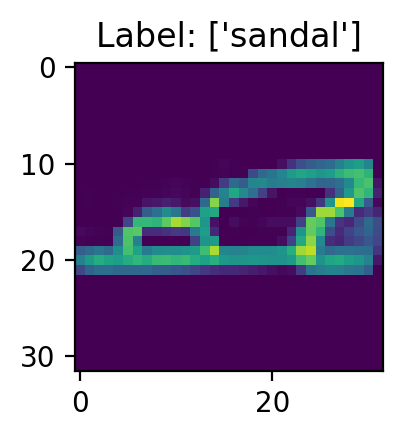

In [6]:
############################################################
# Example how to retrieve and visualize training data
############################################################
#We obtain the next batch from the variable train dataloader
batch1=next(iter(traindataloader))
#batch1 is a list made of 2 elements
print("size of the item coming from dataloader:", len(batch1),": images and labels")
#The batch for the training dataloader comes in the form of two tensors: images and labels
images1, labels1=batch1
#We print the dimensions and values of the tensors obtained
print("Size of the images in the batch:", images1.size())# 64 images
print("Size of the labels in the batch:", labels1.size())# 64 numbers
print("************************************************************************")
print("Here are the contents of the first image of the batch as a tensor:")
print("size of the first image of the batch:", images1[0].size())
print(images1[0])
#We print the corresponding label using the function text_lables. We need first to 
# transform label1[0] into a list.
#list=[labels1[0]]
print("Value of the corresponding numerical value of the label", labels1[0].item())
# we use the function plot_image_label to visualize the content of images1[0]
print("Here is the associated image and label")
plot_image_label(images1[0],labels1[0])

**VARIABLES**

| Variable Name   | Data Type   | Nature of Variable  |
|------------|------------|------------|
|` traindataloader` | `DataLoader` | Data Loader for the data |
|` image1` | `torch.Tensor` | Data preparation |

# Model Definition 

Recall the structure of our classification problem for the images in FashionMNIST. 

* Each **input** to the neural network in each instance will be represented by a fixed-length vector.
Since the raw data here consists of $32 \times 32$ pixel images, we *flatten* each image,
treating them as vectors of length $32\times 32=1024$.

* The **output** is a vector of size ten, which we call $\mathbf{o}$ wich will give us the **probabilities** that the image is in one of the ten categories.

So the structure of the neural network can be imagined as the following matrix operations:
$$
\mathbf{0}=\mathbf{W}\cdot \mathbf{x}+ \mathbf{b}
$$
$$
\begin{bmatrix}
o_{1} \\ o_{2} \\ \ldots \\  o_{10}
\end{bmatrix}=
\begin{bmatrix} w_{1,1} & w_{1,2} & \ldots & w_{1,1024}\\ w_{2,1} & w_{2,2} & \ldots & w_{2,1024}\\ \ldots\\w_{10,1} & w_{10,2} & \ldots & w_{10,1024}\end{bmatrix}\cdot 
\begin{bmatrix} x_{1}  \\
x_{2}  \\
\ldots \\
 x_{1024} 
\end{bmatrix}\
+\begin{bmatrix} b_1 \\ b_2 \\ \ldots \\ b_{10}\end{bmatrix}
$$


Consequently, our weights constitute a $10\times1024$ matrix plus a $10\times1$ row vector for the biases.

We are going to construct this neural network in **Pytorch**, using the class `nn.Sequential`.


### The nn.Sequential class

`nn.Sequential` models are well-suited for implementing linear classification problems due to their simplicity and flexibility. They are particularly effective for tasks involving a fixed number of input features and a single output, such as classifying images into predefined categories.

* *Simplicity*: `nn.Sequential` models are constructed by sequentially stacking layers, making them straightforward to design and implement. This simplicity allows for easy experimentation with different layer combinations and hyperparameters to optimize model performance.

* *Flexibility*: `nn.Sequential` models can accommodate a variety of layer types, including linear layers, activation functions, and pooling layers. This flexibility enables the creation of models tailored to specific classification tasks. For instance, adding more linear layers can increase model complexity to capture more intricate patterns in the data.

* *Efficiency*: `nn.Sequential` models are computationally efficient, particularly for smaller datasets. Their straightforward structure simplifies forward and backward propagation during training, reducing computational overhead compared to more complex network architectures.



* *Interpretability*: `nn.Sequential` models are relatively interpretable due to their clear layer-based structure. This interpretability allows for understanding the decision-making process of the model and identifying potential biases or overfitting issues.

> In summary, `nn.Sequential` models offer a balance between simplicity, flexibility, efficiency, and interpretability, making them a preferred choice for implementing linear classification problems. Their ease of use and adaptability allow for rapid prototyping and optimization, while their interpretability facilitates model evaluation and refinement.

> 👉🏾 As with linear regression, we initialize the weights `W` with Gaussian noise. The biases are initialized as zeros.


Study the following code with care.
It defines our model as a linear classification model using Pytorch.

Note in particular the line:
```Python
classification_model = nn.Sequential(nn.Flatten(), nn.Linear(num_inputs, num_outputs))
```
---
<details>
  <summary><b>Detailed Explanation of the Code Below</b></summary>
Here it is:
    <ol>
        <li> `nn.Sequential()`. Purpose: This container allows you to chain together a sequence of layers or operations. The output of one layer becomes the input for the next.
In this case: Two layers are defined inside the nn.Sequential container: nn.Flatten() and nn.Linear(num_inputs, num_outputs).
    	<li>`nn.Flatten()`. Purpose: The `nn.Flatten()` layer reshapes the input tensor to a 1D tensor (a flat vector). It's typically used to prepare multi-dimensional input data (like images) for a fully connected layer.
Input and output: If the input is a batch of images (e.g., `shape (batch_size, channels, height, width))`, `nn.Flatten()` will convert it to shape (batch_size, channels * height * width). This transformation ensures that the subsequent `nn.Linear` layer can process the data.
    	<li>V `nn.Linear(num_inputs, num_outputs)`. Purpose: This is a fully connected layer (also called a dense layer). It performs a linear transformation of the input data using learned weights and biases.
num_inputs: The number of input features (i.e., the size of the flattened input).
num_outputs: The number of output features, which usually corresponds to the number of classes in a classification task.
    </ol>
  

</details>

---


In [7]:
############################################################
#Model definition
############################################################
num_inputs = 1024 # Inputs of the neural networtk
num_outputs = 10# output of the neural network
#Define the classification_model
classification_model = nn.Sequential(nn.Flatten(), nn.Linear(num_inputs, num_outputs))
#Initialization phase
sigma = 0.01#Define standard deviation
#Initialize weights randomly
classification_model[1].weight.data = torch.normal(0, sigma, size=(num_outputs, num_inputs), requires_grad=True)
#Initialize bias data
classification_model[1].bias.data = torch.zeros(num_outputs, requires_grad=True)

**VARIABLES**

| Variable Name   | Data Type   | Nature of Variable  |
|------------|------------|------------|
|` traindataloader` | `DataLoader` | Data Loader for the data |
|` image1` | `torch.Tensor` | Data preparation |
| `num_inputs` | `int`| Model Definition: number of inputs |
|  `num_outputs` | `int`| Model Definition: number of outputs |
|  `classification_model` | `torch.nn.Sequential` | Model Definition: The model itself |

## Forward Pass of the Model

Although not necessary for the training, we illustrate how we can calculate the forward pass of this model.

Input image to neural network


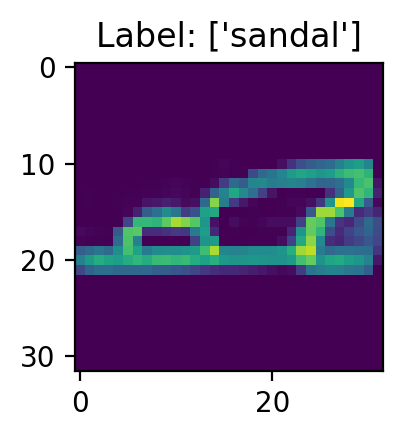

Label value tensor(5)
input size: torch.Size([1, 32, 32])
Output of neural network

tensor([[ 0.0221,  0.0042, -0.0186, -0.0316,  0.0649, -0.0235,  0.0642, -0.0387,
         -0.0346,  0.0802]])
predicted index:  tensor(9)


In [8]:
############################################################
# Example Forward pass of model
############################################################
#Disable gradient calculator and set neural network to evaluation mode
with torch.no_grad():
    # Input of the neural network
    input=images1[0]
    label= labels1[0]# This is not needed, it is just the label associated with the input in the data.
    print("Input image to neural network")
    plot_image_label(input,label)
    print("Label value", label)
    #input of neural network
    print("input size:", input.shape)
    #output of the neural network.
    output=classification_model(input)# This is the forward pass.
    print("Output of neural network\n")
    print(output)
    #we can select the highest value of the output using the function argmax
    # Find the index with the highest value using argmax
    highest_index = torch.argmax(output)
    # Print the index
    print("predicted index: ", highest_index)  # Output: 2

# The Loss Function

As mentioned before, defining the loss function for a classification problem is different from defining it for a regression problem. 

To understand the differences, we need to introduce some key concepts.

## The Softmax
:label:`subsec_softmax_operation`

We are interested in **predictions** for linear classification model, so given the output $\mathbf{o}=(o_1,o_2,\ldots,0_q)$ we want:

1. to transforms the outputs $\mathbf{o}$ into $\mathbf{p}$, a  **probability distributions**, that is,  a collection of probabilities that tells us what are the probabilities of belonging to each class. 

2. Then we want to use these probabilities to decide which one of the label is the one being predicted.

How to achieve these steps?

### Transforming the Outputs into Probabilities

First, we need to decide how to make the outputs $\mathbf{o}$ of the linear network into probability distribution $\mathbf{p}$. 

Recall:

---

**PROBABILITY DISTRIBUTION**

A finite probability distribution are vectors $\mathbf{p}=(p_1,p_2,\ldots, p_n)$ such that:
1. Every $p_i$ is a number between 0 and 1 
2. $\sum_{i=1}^n p_i=1$.

---
* So for example, the output $(-1,2,5)$ is not a set of probability distributions, nor is the output $(0.1, 0.3, 0.3)$ since the sum of the probabilities is not one.


One way to accomplish this goal (and to ensure nonnegativity) is to use an exponential function $P(y = i) \propto \exp o_i$ (transforms each one of the outputs into a positive number) and a process of normalization (dividing every value by the sum of all the values).

Putting these two pieces together gives us the *softmax* function:
$$
\hat{\mathbf{p}}=(\hat{p}_1, \hat{p}_2,\ldots, \hat{p}_n) =
$$
$$
\mathrm{softmax}(\mathbf{o}) \quad \textrm{where}\quad  \hat{p}_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)}. \tag{eq-softmax-y-and-o}
$$

* Note that the largest coordinate of $\mathbf{o}$ corresponds to the most likely class according to $\hat{\mathbf{p}}$.

* Moreover, because the `softmax` operation preserves the ordering among its arguments, we do not need to compute the `softmax` to determine which class has been assigned the highest probability. 

Thus,
$$
\operatorname*{argmax}_j \hat p_j = \operatorname*{argmax}_j o_j.
$$


The idea of a softmax dates back to :citet:`Gibbs.1902`, who adapted ideas from physics.

### Example of Softmax Calculation


We will illustrate a Softmax calculation in **Pytorch** by selecting a simple example, and using the **Pytorch** function `torch.nn.functional.softmax`, which is an implementation of the Softmax formula.

Consider the following tensor: `output_data`=[1,1,1].

To transform it into a **Softmax** probability distribution we first generate `exp(output_data)`=$[e^1,e^1,e^1]$, and then calculate:

$$
\text{softmax(output\_data)}=
$$
$$[\frac{e^1}{e^1+e^1+e^1}, \frac{e^1}{e^1+e^1+e^1}, \frac{e^1}{e^1+e^1+e^1}]=[\frac{1}{3},\frac{1}{3},\frac{1}{3}]
$$

In [18]:

# Define the input tensor
input_array = torch.tensor([2.0, -3.1, 4.0, 6.0])

# Calculate the softmax
softmax_output = torch.softmax(input_array, dim=0)

# Print the result
print(softmax_output)

tensor([1.5875e-02, 9.6784e-05, 1.1730e-01, 8.6673e-01])


###  Cross-Entropy

Now that we have a mapping from features $\mathbf{x}$
to probabilities $\mathbf{\hat{p}}$, using **Softmax**, 
we need a way measure the error between the output probability distribution $\mathbf{\hat{p}}$ and the labels coming from the training data.

This requires us to defined a loss function for the probabilities observed ($\mathbf{\hat{p}}$) compared to the probabilities given by the data ($\mathbf{l}$). We call the probabilities on the data and the probabilities obtained via Softmax **probability distributions**.

<div class="alert alert-block alert-info">
<b>NOTE</b> The output of the linear classification model, $\mathbf{o}$, before they are transformed into probability distributions, are called **logits**. See <a href="https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean">here</a>

</div>



**DEFINITION**

**Cross-entropy** is a measure of the difference between two probability distributions for a given random variable or set of events.

**Cross entropy** loss is a metric used in machine learning to measure how well a classification model performs. The loss (or error) is measured as a number between 0 and 1, with 0 being a perfect model. The goal is generally to get your model as close to 0 as possible.


* **Cross entropy** loss measures the difference between the discovered probability distribution of a machine learning classification model and the predicted distribution. 

* All possible values for the prediction are stored so, for example, if you were looking for the odds in a coin toss, it would store that information at 0.5 and 0.5 (heads and tails).

Given a probability distribution  $\hat{p}=(\hat{p}_1,\hat{p}_2,\ldots, \hat{p}_n)$ obtained via **Softmax** from the running of a neural network over a set of inputs, and a target probability distribution $\mathbf{l}=(l_1,l_2,\ldots,l_n)$, the **Cross-Entropy loss** is given by:
$$
L=−\sum_{i} l_i\log(\hat{p}_i).
$$

---



### The Theory Behind the Cross-Entropy Loss

>⚙️ Using **cross-entropy**, we can measure the error (or difference) between two probability distributions. 

For example, in the case of Binary Classification problem with two classification values with probabilities $0$ and $1$, in other words with  $\mathbf{l}=(l_1,l_2)=(0,1)$, and the output of a neural network, transformed into a probability distribution $\hat{p}=(p_1,p_2)$, the  **cross-entropy** is given by:
$$
L=−( l_1 \log(p_1)  +  l_2\log(p_2) ).
$$

In this case, 
$$L=−(  0×\log(p_1)+1  \log(p_2)  )$$
$$L=−\log(p_2)$$




* The value of the loss $L$ thus depends on the probability $p_2$ obtained from the neural network. 

* Therefore, our loss function will reward the model for giving a correct prediction (high value of $p_2$, i.e $p_2$ close to 1) with a low loss. However, if the probability is lower, the value of the error will be high (bigger negative value), and therefore it penalizes the model for a wrong outcome.

<div class="alert alert-block alert-warning">
<b>OBSERVATION</b> If $\hat{\mathbf{p}}$ is a probability vector then for every single entry of $\hat{p}$ we have that $0\leq p_i\leq 1$, which implies that $0\leq -\log(p_i)$. 
    Note also that $L(\mathbf{l}, \hat{\mathbf{p}}) = 0$ only if we predict
the actual label with"certainty" ($p_i=1$).This can never happen for any finite setting of the weights
because taking a softmax output towards $1$
requires taking the corresponding input $o_i$ to infinity
(or all other outputs $o_j$ for $j \neq i$ to negative infinity).
Even if our model could assign an output probability of $0$,
any error made when assigning such high confidence
would incur infinite loss ($-\log 0 = \infty$).
</div>

## Using  `F.cross_entropy`

In **pytorch** the function `cross_entropy` can be used to calculate the cross entropy loss.

We ilustrate this with an example.

Consider the following output tensor: `output_data`=[1,1,1].

To transform it into a probability distribution using **Softmax** we first generate `exp(output_data)`=$[e^1,e^1,e^1]$, and then calculate:
$$
\hat{y}=\text{softmax(output\_data)}=[\frac{e^1}{e^1+e^1+e^1}, \frac{e^1}{e^1+e^1+e^1}, \frac{e^1}{e^1+e^1+e^1}]=[\frac{1}{3},\frac{1}{3},\frac{1}{3}]
$$


We now want to compare that vector $\hat{p}=$`softmax(output_data)` ( a sofmax generated probability distribution) with a target probability distribution with label class $1$. This corresponds to a tensor probability ditribution $y=$ `target=[0,1,0]`. We calculate the Cross Entropy loss using the formula:
$$
L=−\sum_{i} y_i\log(\hat{y}_i),
$$
as follows:
$$
L=-\left(0\ln(\frac{1}{3})+0\ln(\frac{1}{3})+1.0\ln (\frac{1}{3})\right)=-\ln(\frac{1}{3})=1.0986.
$$
Similarly, if the target label has value $0$, the the corresponding tensor probability distribution is $y=$ `target=[1,0,0]` and the Cross Entropy Loss is given by:
$$
L=-\left(1.0\ln(\frac{1}{3})+0\ln(\frac{1}{3})+0\ln (\frac{1}{3})\right)=-\ln(\frac{1}{3})=1.0986.
$$


### Using the loss function


Let us illustrate the use of the function `F.cross_entropy` by calculating the cross entropy loss obtained in the previous example, with the output data batch of tensors given by: `output_data`=[1.0,1.0,1.0],[1.0,1.0,1.0],[1.0,1.0,1.0]  and the target probability distributions given by  `labels:0,0,1`.
In the manual calculation done in the previous example we obtained $l=1.0986$.

we define first our function loss for this training problem using the function `F.cross_entropy` as shown below.

In [14]:
######################################
# Loss function
#####################################
def loss(Y_hat, Y):#Y_hat is the predicted probability distribution, Y is the labels
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return cross_entropy(Y_hat, Y, reduction="mean")

Reshaping Predicted Pobabilities (Y_hat):

```python
Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
```
**Purpose**: The reshaping is performed to ensure that the shape of `Y_hat` is suitable for calculating the loss.

**Explanation**:
`Y_hat.shape[-1]` retrieves the last dimension of the tensor, which typically corresponds to the number of classes in a classification problem.
``(-1, Y_hat.shape[-1])`` reshapes `Y_hat` to have an unspecified number of rows (which will be automatically determined based on the total number of elements) and a fixed number of columns equal to the number of classes.
Result: This transformation ensures that `Y_hat` has a shape of `(N,C)`, where N is the number of samples and C is the number of classes.

Reshaping Labels (Y):

```python
Y = Y.reshape((-1,))
```
**Purpose**: Similar to `Y_hat`, this reshapes the label tensor `Y.`

**Explanation**:
(-1,) reshapes Y into a one-dimensional tensor (flattening it). This is necessary because the labels should be a one-dimensional tensor where each entry corresponds to the true class index for the respective sample.
Result: This ensures that Y has a shape of (N,)

Once our loss function is defined we illustrate how to use it. 

In [49]:
############################################################
# Example using the Loss function
############################################################
#We test the function loss with the following batch of tensor values and the associated target
# labels
outputs = torch.tensor([[1.0, 1.0, 1.0],
                       [2.0, 2.0, 2.0],
                       [3.0, 3.0, 3.0]], dtype=torch.float)
print("size of  tensor outputs=", outputs.size())
#We use the following target of tensor of the corresponding labels of the data 
targets = torch.tensor([0, 0, 1], dtype=torch.long)#It is important that the
# dtype here is long.
print("size of targets=", targets.size())
print("Target probability distribution:",targets)
# Calculate cross-entropy loss using our newly defined function
print("Cross-entropy loss:", loss(outputs, targets))# this loss function value is 
#the average of the loss function for the three elements of the batch

size of  tensor outputs= torch.Size([3, 3])
size of targets= torch.Size([3])
Target probability distribution: tensor([0, 0, 1])
Cross-entropy loss: tensor(1.0986)


>⚙️ **NOTE**: Observe that the output of the pytorch function `cross-entropy` use in our definition of the function `los` is a tensor of dimension 1, not a number.

**VARIABLES**

| Variable Name   | Data Type   | Nature of Variable  |
|------------|------------|------------|
|` traindataloader` | `DataLoader` | Data Loader for the data |
|` image1` | `torch.Tensor` | Data preparation |
| `num_inputs` | `int`| Model Definition: number of inputs |
|  `num_outputs` | `int`| Model Definition: number of outputs |
|  `classification_model` | `torch.nn.Sequential` | Model Definition: The model itself |
|  `loss` | `float` | The cross entropy loss function |


# Defining the Optimizer
In this step, we decide of to optimize our model. We will use the Stochastic Gradient Descent method, and will define the value of the parameter $lr$ to be $0.06$.

In [50]:
############################################################
# Defining the Optimizer
############################################################
# Instantiate an SGD optimizer for training the classification model:
classoptimizer = optim.SGD(classification_model.parameters(), lr=0.06)

**VARIABLES**

| Variable Name   | Data Type   | Nature of Variable  |
|------------|------------|------------|
|` traindataloader` | `DataLoader` | Data Loader for the data |
|` image1` | `torch.Tensor` | Data preparation |
| `num_inputs` | `int`| Model Definition: number of inputs |
|  `num_outputs` | `int`| Model Definition: number of outputs |
|  `classification_model` | `torch.nn.Sequential` | Model Definition: The model itself |
|  `loss` | `float` | The cross entropy loss function |
|  `classoptimizer` | `optim.SGD` | stochastic gradient optimizer variable |
|  `lr` | `float` | learning rate for the optimization process |

# The Training
We are now ready to train our model. The next code segment not only trains the model, it also graphs the error and accuracy of the model in every epoch.

In [53]:
######################################
# Training
#####################################
#####Initializing parameters#####
max_epochs = 5
total_epoch_loss=[]
final_accuracy=[]
for epoch in range(max_epochs):# Iterate for every epoch
    ###########Initialization batch loop#################
    correct = 0# Intializes the counter of the number of correct predictions in the epoch
    total = 0## stores total number of elements in the batch
    total_loss=0.0#Total loss per epoch
    for data, target in traindataloader:#Go over all the batches
        classoptimizer.zero_grad()#ensures that the new gradients calculated in the current iteration accurately reflects
    #the loss at the current parameter values.
        #####Forward pass#####
        output = classification_model(data)#Calculates the output of the neural network with the input from the batch.
        #####Calculate loss#####
        batch_loss = loss(output, target)#Calculate the entropy loss for this batch
        #####Backpropagation and optimization#####
        batch_loss.backward()#Performs the calculation of the gradient of the function batch_loss
        classoptimizer.step()# updates the values of the weights using the results of the gradient
        #####Updates values of total errors and # of correct predictions#####
        predicted = torch.argmax(output, dim=1)# Calculate the predicted outputs as labels
        #Calculate the total numbers of cases when the predicted and target labels are the same,
        #and add that number to the variable correct.
        correct += (predicted == target).sum().item()
        #Calculate the total number of elements in the batch
        total += target.size(0)#updates by adding the total number of elements in the batch
        total_loss+=batch_loss.item()#Updates the error from this batch
        #####End Batch Loop#####
    #######We calculate now the average loss and the accuracy for the epoch#######
    epoch_loss= total_loss/len(traindataloader)
    #we append the average loss to the list of epoch losses
    total_epoch_loss.append(epoch_loss)
    # Calculate and print epoch accuracy
    epoch_accuracy = 100. * correct / total
    final_accuracy.append(epoch_accuracy)
    print(f"Epoch: [{epoch+1}/{max_epochs}] | Training Accuracy: {epoch_accuracy:.2f}%")
    #print the epoch error
    print("Epoch error:", epoch_loss)
    ###########End of epoch loop#################

Epoch: [1/50] | Training Accuracy: 84.68%
Epoch error: 0.44641929374002953


Epoch: [2/50] | Training Accuracy: 84.92%
Epoch error: 0.4394832910981768


Epoch: [3/50] | Training Accuracy: 85.08%
Epoch error: 0.4366028039599024


Epoch: [4/50] | Training Accuracy: 85.10%
Epoch error: 0.43207618058808067


Epoch: [5/50] | Training Accuracy: 85.26%
Epoch error: 0.4292257860430014


Epoch: [6/50] | Training Accuracy: 85.29%
Epoch error: 0.42661761050857205


Epoch: [7/50] | Training Accuracy: 85.54%
Epoch error: 0.42241306075536367


Epoch: [8/50] | Training Accuracy: 85.48%
Epoch error: 0.42044029486522494


Epoch: [9/50] | Training Accuracy: 85.55%
Epoch error: 0.4197475165128708


Epoch: [10/50] | Training Accuracy: 85.62%
Epoch error: 0.41827124596309306


Epoch: [11/50] | Training Accuracy: 85.65%
Epoch error: 0.41709958236100575


KeyboardInterrupt: 

We can illustrate the training by plotting the accuracy in the training data and the errors as plots, per each epoch.

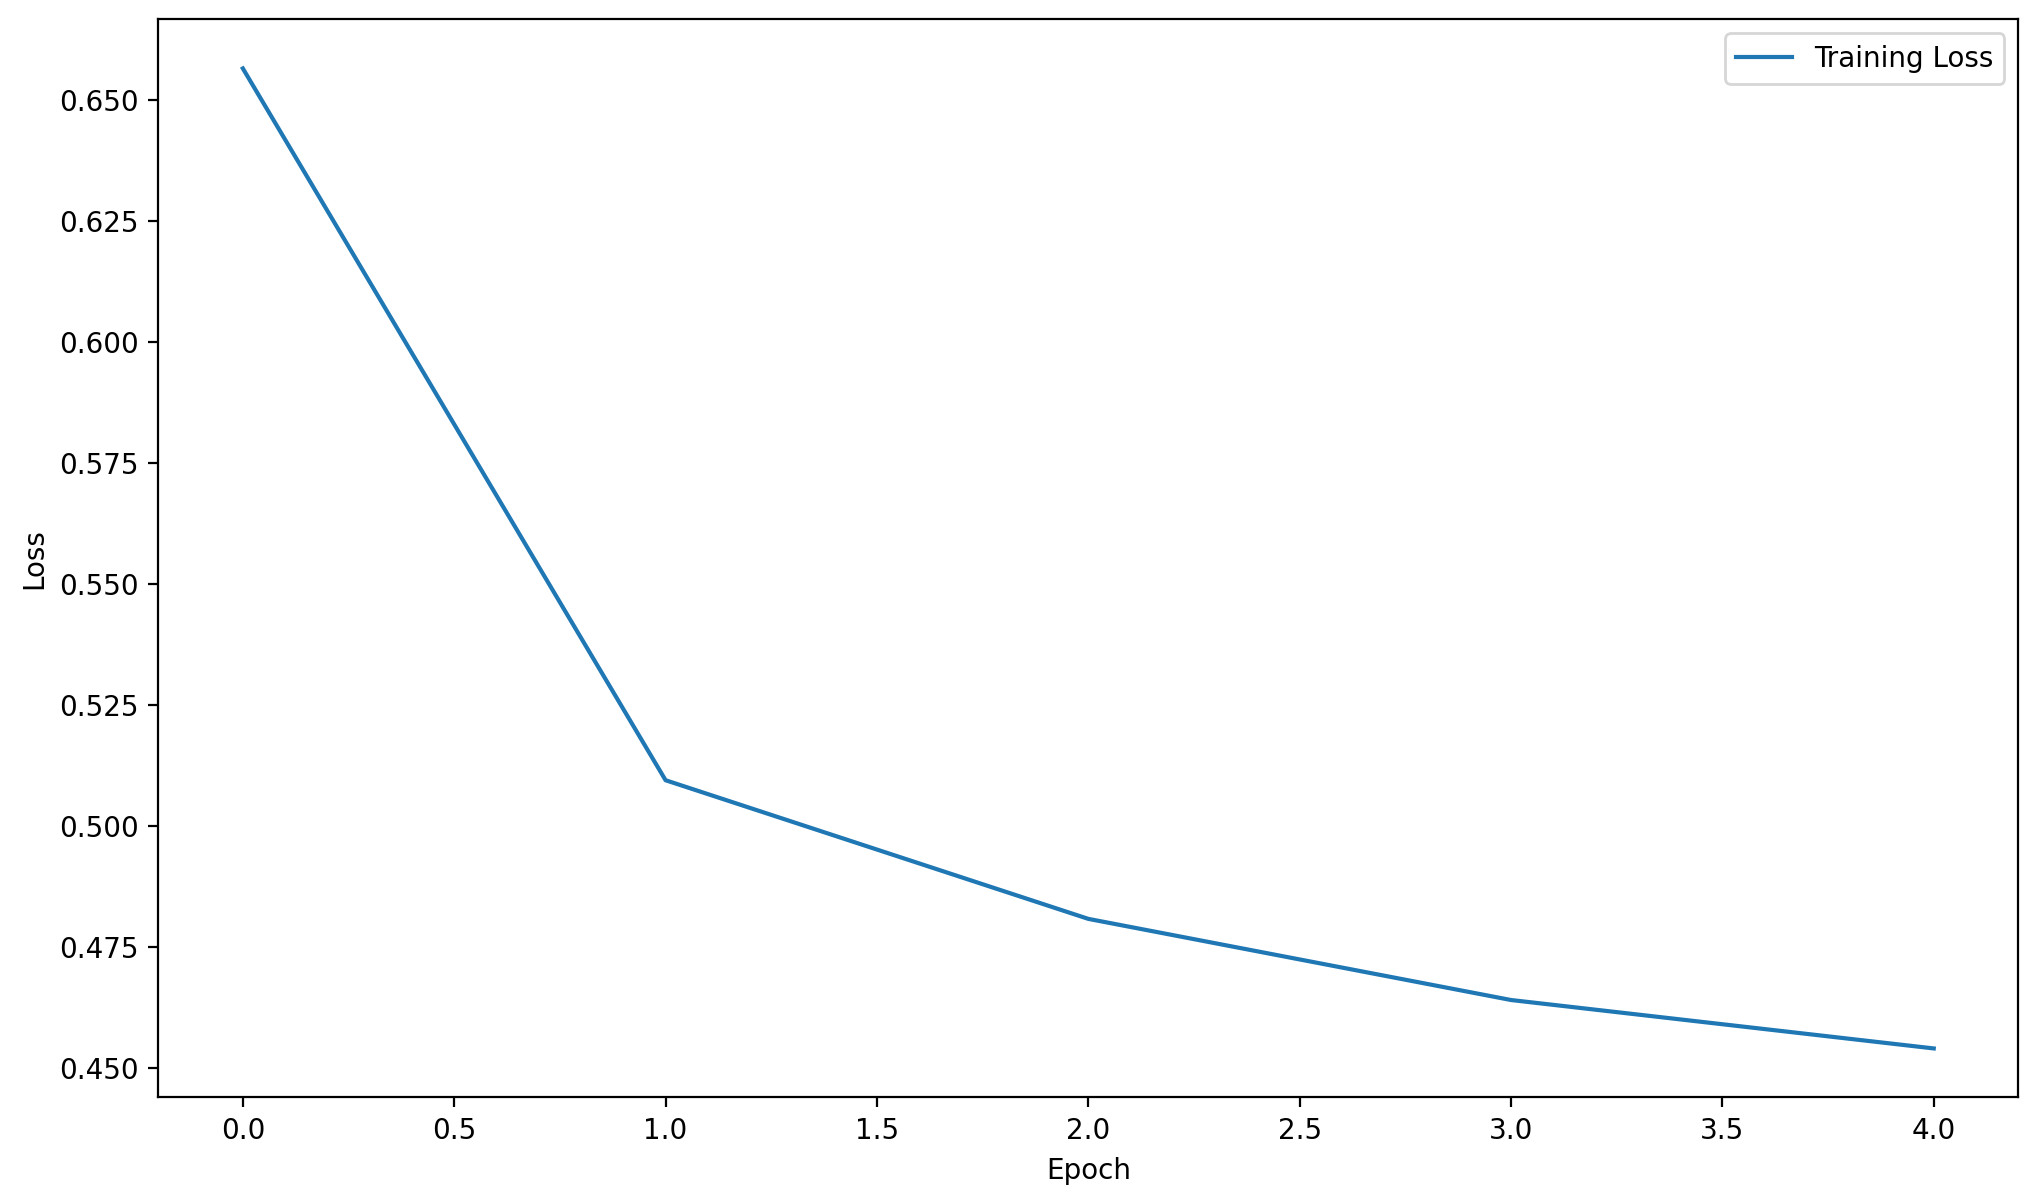

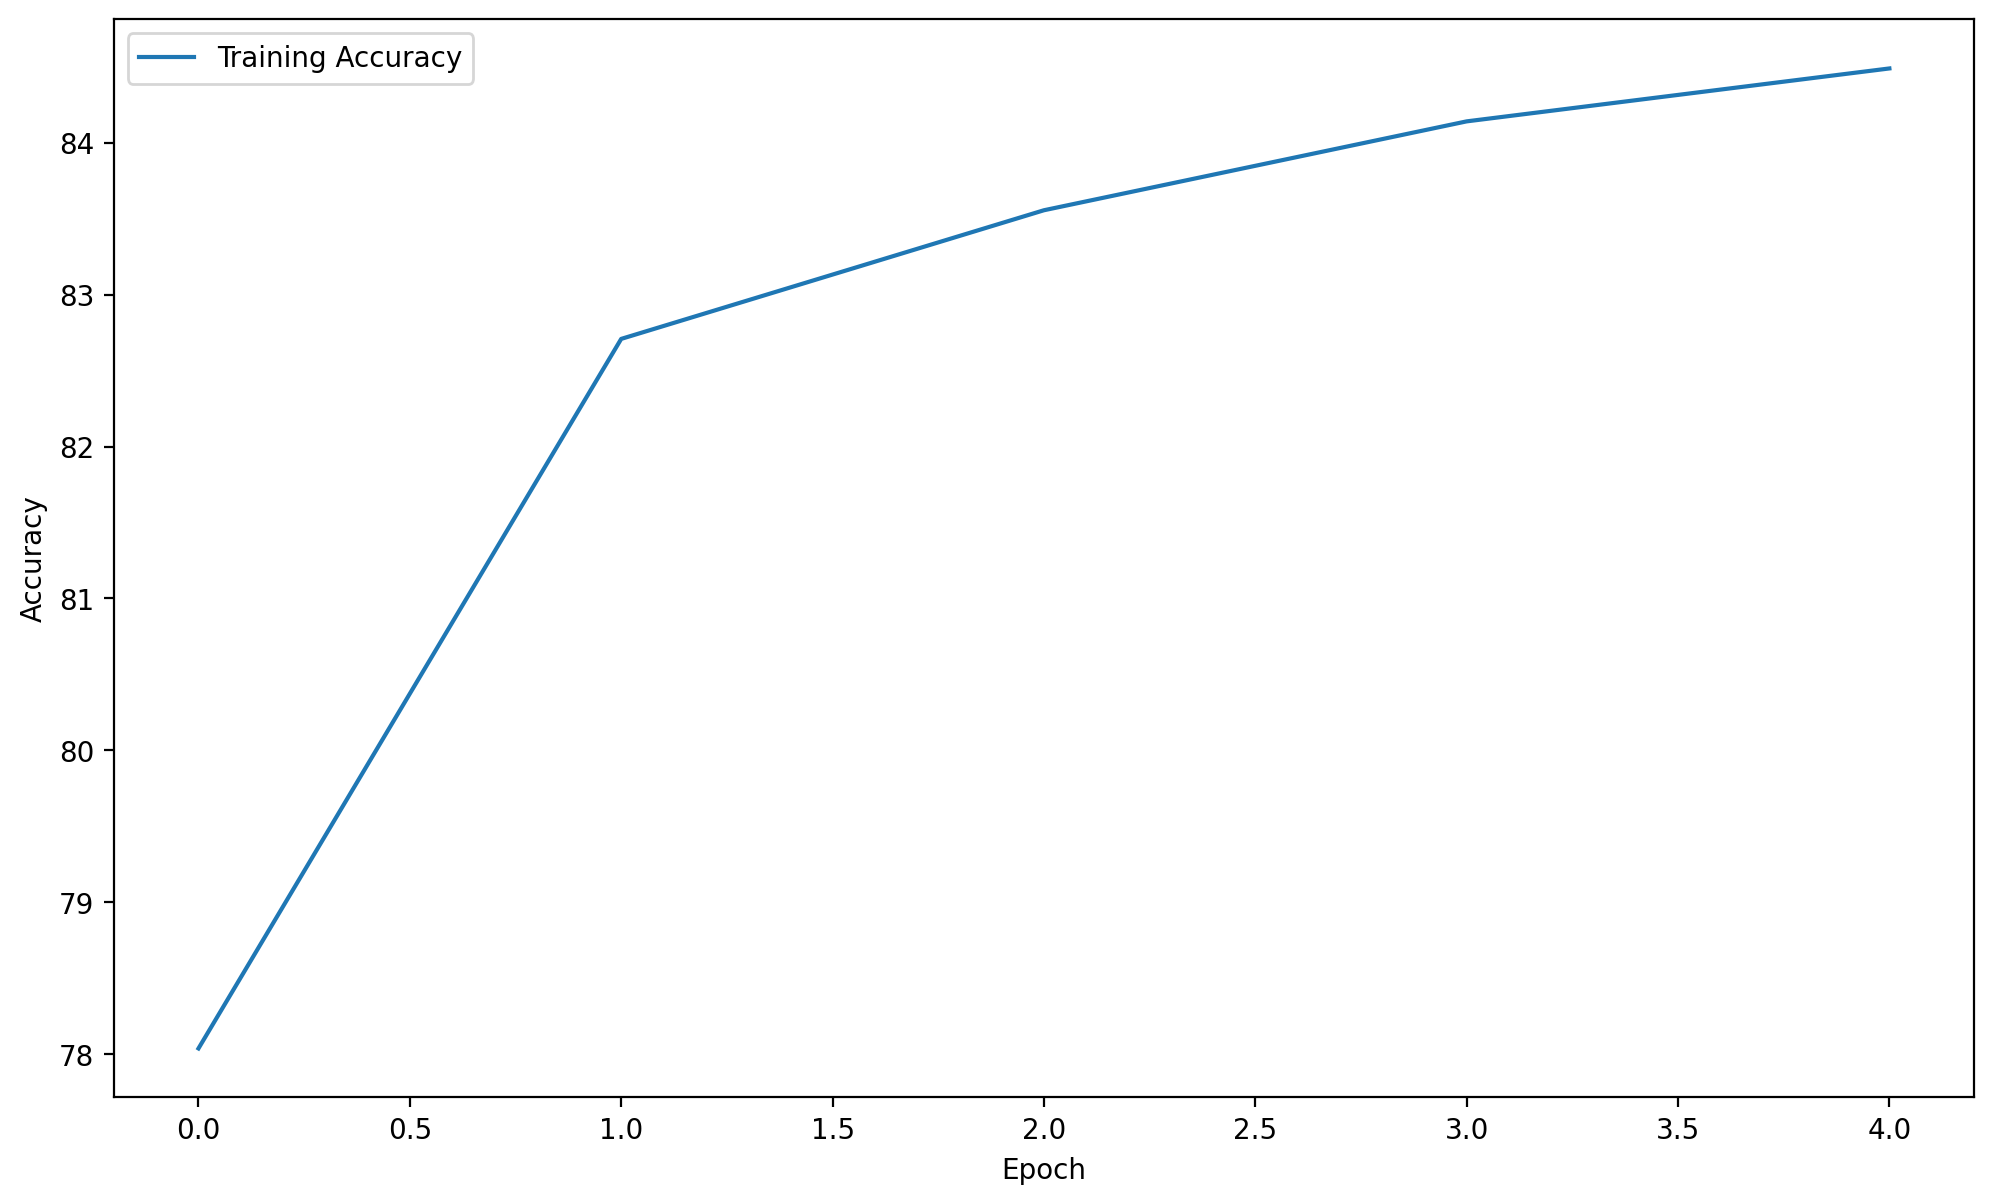

In [52]:
######################################
# Visualization of loss and accuracy
#####################################
with torch.no_grad():# makes sure to be in evaluation mode 
    # we plot now the graph of total_loss values against the epochs.
    plt.plot(total_epoch_loss, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    #We plot now the accuracy of the neural network
    plt.plot(final_accuracy, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

**VARIABLES**

| Variable Name   | Data Type   | Nature of Variable  |
|------------|------------|------------|
|` traindataloader` | `DataLoader` | Data Loader for the data |
|` image1` | `torch.Tensor` | Data preparation |
| `num_inputs` | `int`| Model Definition: number of inputs |
|  `num_outputs` | `int`| Model Definition: number of outputs |
|  `classification_model` | `torch.nn.Sequential` | Model Definition: The model itself |
|  `loss` | `float` | The cross entropy loss function |
|  `classoptimizer` | `optim.SGD` | stochastic gradient optimizer variable |
|  `lr` | `float` | learning rate for the optimization process |
|  `max_epochs` | `int` | Number of epochs |

We can illustrate the precision of this classification tool by visualizing the accuracy of the trained model for a few training images and comparing the calculated labels with the true labels.

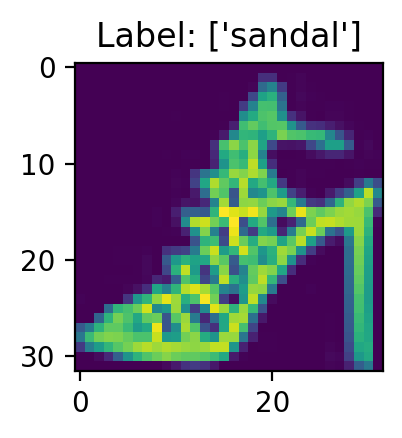

target label: ['sandal']
Label predicted: ['sandal']
*********************************


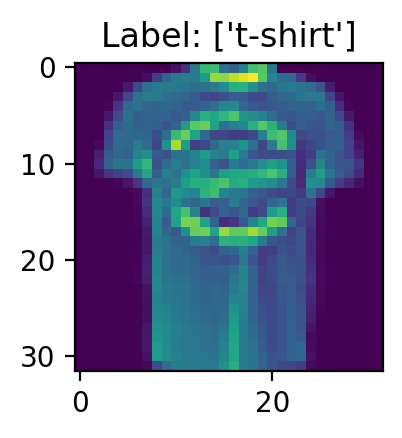

target label: ['t-shirt']
Label predicted: ['t-shirt']
*********************************


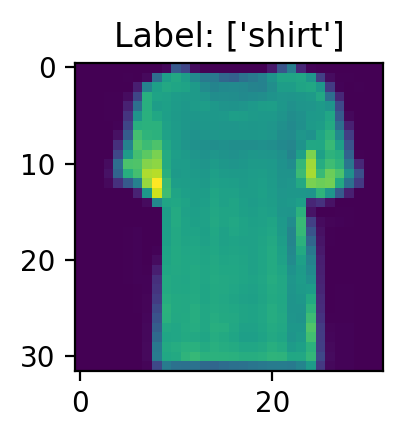

target label: ['shirt']
Label predicted: ['t-shirt']
*********************************


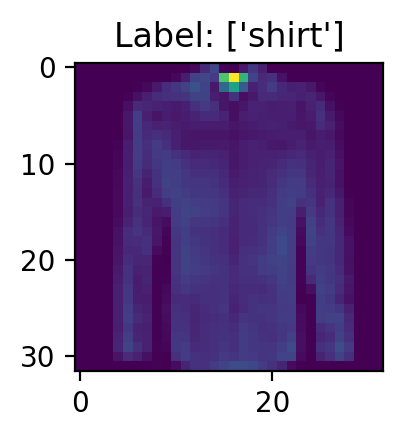

target label: ['shirt']
Label predicted: ['shirt']
*********************************


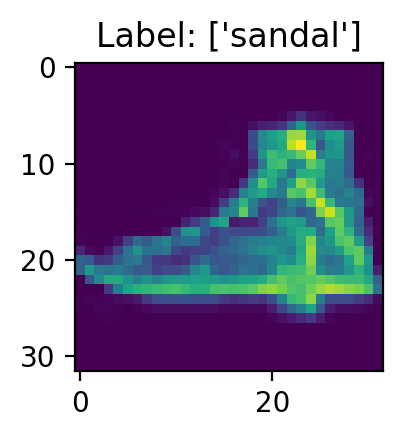

target label: ['sandal']
Label predicted: ['ankle boot']
*********************************


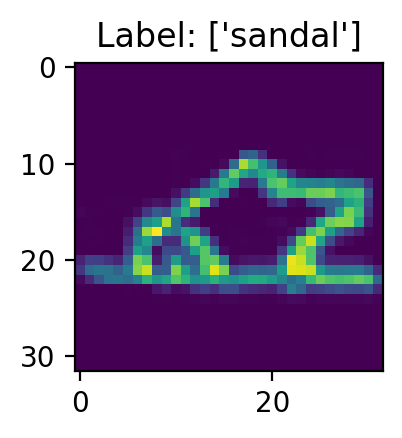

target label: ['sandal']
Label predicted: ['sandal']
*********************************


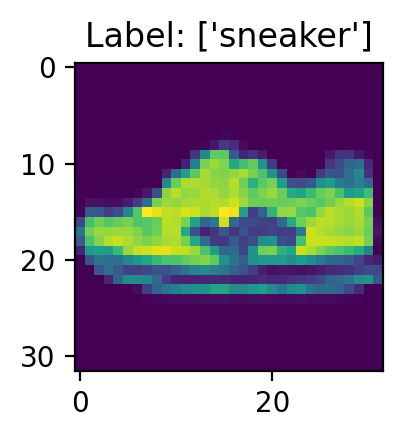

target label: ['sneaker']
Label predicted: ['sneaker']
*********************************


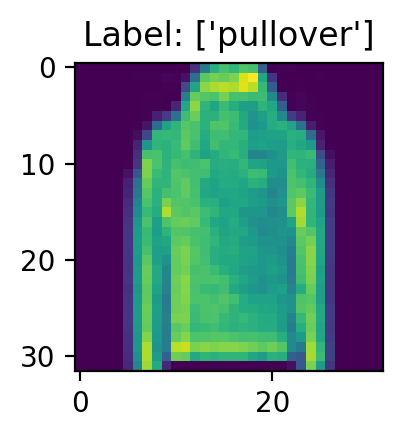

target label: ['pullover']
Label predicted: ['pullover']
*********************************


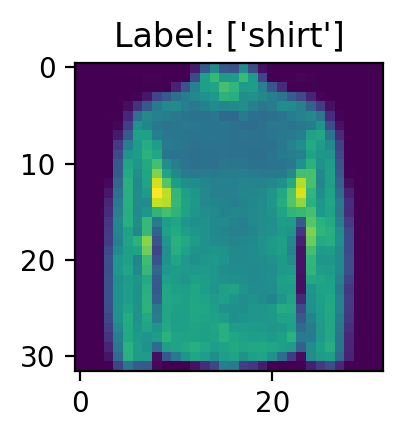

target label: ['shirt']
Label predicted: ['shirt']
*********************************


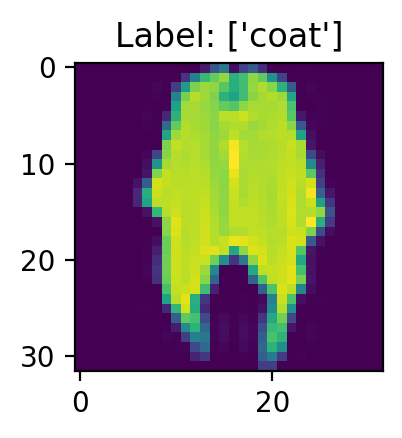

target label: ['coat']
Label predicted: ['coat']
*********************************


In [16]:
######################################
# Example classifier in action
#####################################
with torch.no_grad():# makes sure to be in evaluation mode
    data, target in validatedataloader # Selects the first batch of the validation data
    for i in range(0,10):#Read the first 10 data elements of the batch
        plot_image_label(data[i],target[i])#we plot the ith image of the batch
        labellist=torch.tensor([target[i]])# we process the label of the ith image as text
        print("target label:", text_labels(labellist))
        output = classification_model(data[i])# forward pass for the data in the batch
        predicted = torch.argmax(output, dim=1)#calculate batch the labels predicted
        labelpredicted=torch.tensor([predicted])#we transform the number into a tensor becasue the function text_label only accepts tensors as inputs
        print("Label predicted:",text_labels(labelpredicted))#We calculate the text assocaited with the predicted label
        print("*********************************")            

### Testing the Neural Network

We tested te accuracy of our neural network with respect to the training data. THis should not be done. 

 > 👉🏾The accuracy of the neural network must be tested with a different data set from the one used for training.

For the Fashion MNist data sets, we have a testing data set available.

In [19]:
# Evaluation of our neural network on the test set
correct = 0  # Initialize counter for correct predictions
total = 0    # Initialize counter for total test samples
input_size = 28 * 28  # Each image is 28x28 pixels

# Disable gradient calculation to save memory and computations during evaluation
with torch.no_grad():
    # Iterate through batches of images and labels in the test set
    for images, labels in  validatedataloader:
        #####Forward pass#####
        output = classification_model(images)#Calculates the output of the neural network with the input from the batch.
        predicted = torch.argmax(output, dim=1)# Calculate the predicted outputs as labels
        #Calculate the total numbers of cases when the predicted and target labels are the same,
        #and add that number to the variable correct.
        correct += (predicted == labels).sum().item()
        #Calculate the total number of elements in the batch
        total += labels.size(0)#updates by adding the total number of elements in the batch
        #####End Batch Loop#####
        
        
print(f"Accuracy of the model on the 10,000 test images: {100 * correct / total} %")

Accuracy of the model on the 10,000 test images: 79.01 %


Observe that the evaluation accuracy is less than the one obtained with the training set.

# OOD in Linear Classfication

## Introduction

We will extend the classes defined in the linear regression notebook to create a neural network that can handle classification tasks. Here's an overview of the process:

Recall the classes that we defined for the linear regression problem:


| Class Name | Purpose|
| -------- | ------- |
| `LinerRegressionDataset` | Data Generation |
| `LinearRegressionModel` | Linear Model |
| `MSELossWrapper` | Loss Function |
| `SGDOptimizer` | Optimizer |

Using these classes,  we will create the following classes for a linear classifier:

`ClassificationDataset`: This class will handle the dataset for classification, similar to LinearRegressionDataset.

`ClassificationModel`: This will inherit from nn.Module, and handle the structure of the neural network, using a fully connected layer for classification.

`CrossEntropyLossWrapper`: A wrapper around the nn.CrossEntropyLoss function for classification loss.

`SGDOptimizer:` The same class can be reused for handling optimization during training.


## Definition of  the Classes


### Class `LinearClassificationModel`


We'll reuse the structure of the `LinearRegressionModel` but adapt it for classification.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearClassificationModel(nn.Module):
    """
    Linear classification model using nn.Linear.
    This extends the regression model to output multiple classes.
    """
    def __init__(self, input_features, output_classes):
        super(LinearClassificationModel, self).__init__()
        # Define a fully connected layer
        self.linear = nn.Linear(input_features, output_classes)
    
    def forward(self, X):
        # Linear forward pass
        logits = self.linear(X)
        # Apply softmax to get probabilities
        probs = F.softmax(logits, dim=1)
        return probs

**QUESTION 1**:

How many attributes (fields) does the `LinearClassificationModel` class have? What is the purpose of each attribute?


Answer: 



**QUESTION 2**:

Write a PyTorch code snippet that demonstrates how to declare, initialize, and use the `LinearClassificationModel` class for a dataset with 784 input features and 10 output classes.

Output probabilities: 

tensor([[0.0532, 0.2344, 0.0668, 0.1017, 0.1219, 0.0494, 0.1422, 0.0405, 0.0665,
         0.1233],
        [0.1215, 0.0423, 0.0522, 0.1041, 0.2720, 0.1068, 0.0950, 0.0419, 0.1262,
         0.0381],
        [0.0626, 0.1865, 0.1017, 0.0750, 0.0279, 0.1163, 0.0385, 0.2088, 0.1273,
         0.0554],
        [0.0784, 0.1875, 0.0560, 0.1378, 0.0556, 0.1331, 0.1191, 0.0854, 0.0711,
         0.0759],
        [0.1889, 0.0738, 0.0403, 0.0691, 0.0366, 0.0425, 0.1711, 0.2646, 0.0761,
         0.0371],
        [0.1673, 0.0462, 0.1186, 0.1283, 0.0597, 0.0562, 0.1095, 0.0525, 0.2000,
         0.0618],
        [0.3445, 0.0731, 0.0964, 0.0433, 0.0289, 0.1095, 0.0611, 0.0803, 0.0675,
         0.0954],
        [0.1506, 0.0517, 0.0843, 0.0817, 0.1140, 0.1005, 0.0609, 0.2511, 0.0595,
         0.0457],
        [0.0624, 0.0522, 0.1231, 0.0661, 0.0911, 0.1617, 0.0635, 0.1316, 0.0692,
         0.1791],
        [0.1335, 0.0746, 0.0577, 0.0760, 0.0504, 0.0579, 0.2582, 0.1185, 0.1044,
         0.0687],
        [0

This will output a tensor of size [64, 10] representing the probability distribution over 10 classes for each of the 64 input samples.

**QUESTION 3**:

Explain how the *softmax* function is used in the `LinearClassificationModel` class and what its role is in classification tasks.


Answer: 



### Class `CrossEntropyLossWrapper`

We'll create a simple wrapper for the `CrossEntropyLoss`, similar to the loss wrapper from the regression example.

In [23]:
class CrossEntropyLossWrapper:
    """
    Wrapper class for CrossEntropyLoss.
    """
    def __init__(self):
        self.criterion = nn.CrossEntropyLoss()
    
    def __call__(self, predictions, targets):
        return self.criterion(predictions, targets)

**QUESTION 4**:

How many methods and fields does the `CrossEntropyLossWrapper` class have? What is the purpose of each?


Answer: 



**QUESTION 5**:

Write a PyTorch code snippet that demonstrates how to declare, initialize, and use the `CrossEntropyLossWrapper` class to calculate the loss between predicted outputs and target labels.

In [24]:
# Create an instance of CrossEntropyLossWrapper


# Example predictions (logits) and true labels
 # 64 samples, 10 classes (logits before softmax)
 # 64 true labels in the range [0, 9]

# Calculate the loss


Cross-entropy loss: 2.69079327583313


**Question 6**:

What is the purpose of using cross-entropy loss in classification tasks?


Answer: 



### Class `SGDOptimizer`

We can reuse the `SGDoptimizer` class from the linear regresssion classes without modification.

In [25]:

class SGDOptimizer:
    """
    Wrapper class for SGD optimizer.
    """
    def __init__(self, model_params, lr=0.01):
        self.optimizer = torch.optim.SGD(model_params, lr=lr)
    
    def zero_grad(self):
        self.optimizer.zero_grad()
    
    def step(self):
        self.optimizer.step()

**QUESTION 7**:

How many methods and fields are in the `SGDOptimizer` class? What does each method do?


Answer: The `SGDOptimizer` class has:



**QUESTION 8**:

Write a PyTorch code snippet that demonstrates how to declare, initialize, and use the `SGDOptimizer` class to optimize a model.

In [26]:
# Assume 'model' is an instance of a neural network with parameters to optimize

# Create an instance of SGDOptimizer


# Example training loop for one batch
  # Perform forward pass
 # Calculate loss

 # Zero the gradients
  # Backpropagate the gradients
  # Update the parameters

**QUESTION 9**:

Why do we call `zero_grad` before calling `backward` in the optimization process?

Answer: 



## Solving the FashionMNIST Problem

You can now use the classes defined above and train them on `FashionMNIST` following the same structure as in the training of the linear regresson networks with classes.

In [27]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 1: Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Step 2: Define model, loss, and optimizer
input_size = 28 * 28  # Each image is 28x28 pixels
num_classes = 10  # 10 classes in FashionMNIST

model = LinearClassificationModel(input_size, num_classes)
loss_fn = CrossEntropyLossWrapper()
optimizer = SGDOptimizer(model.parameters(), lr=0.01)

# Step 3: Training loop
epochs = 5
for epoch in range(epochs):
    total_loss = 0.0
    for images, labels in train_loader:
        images = images.view(-1, input_size)  # Flatten images
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    #we append the average loss to the list of epoch losses
    total_epoch_loss.append(epoch_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader)}")
    
# Step 4: Evaluation on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the 10,000 test images: {100 * correct / total} %")

Epoch [1/5], Loss: 1.9454757168348917


Epoch [2/5], Loss: 1.8205210187796081


Epoch [3/5], Loss: 1.7951230845217512


Epoch [4/5], Loss: 1.7826595516092996


Epoch [5/5], Loss: 1.724891846113876


Accuracy of the model on the 10,000 test images: 77.22 %


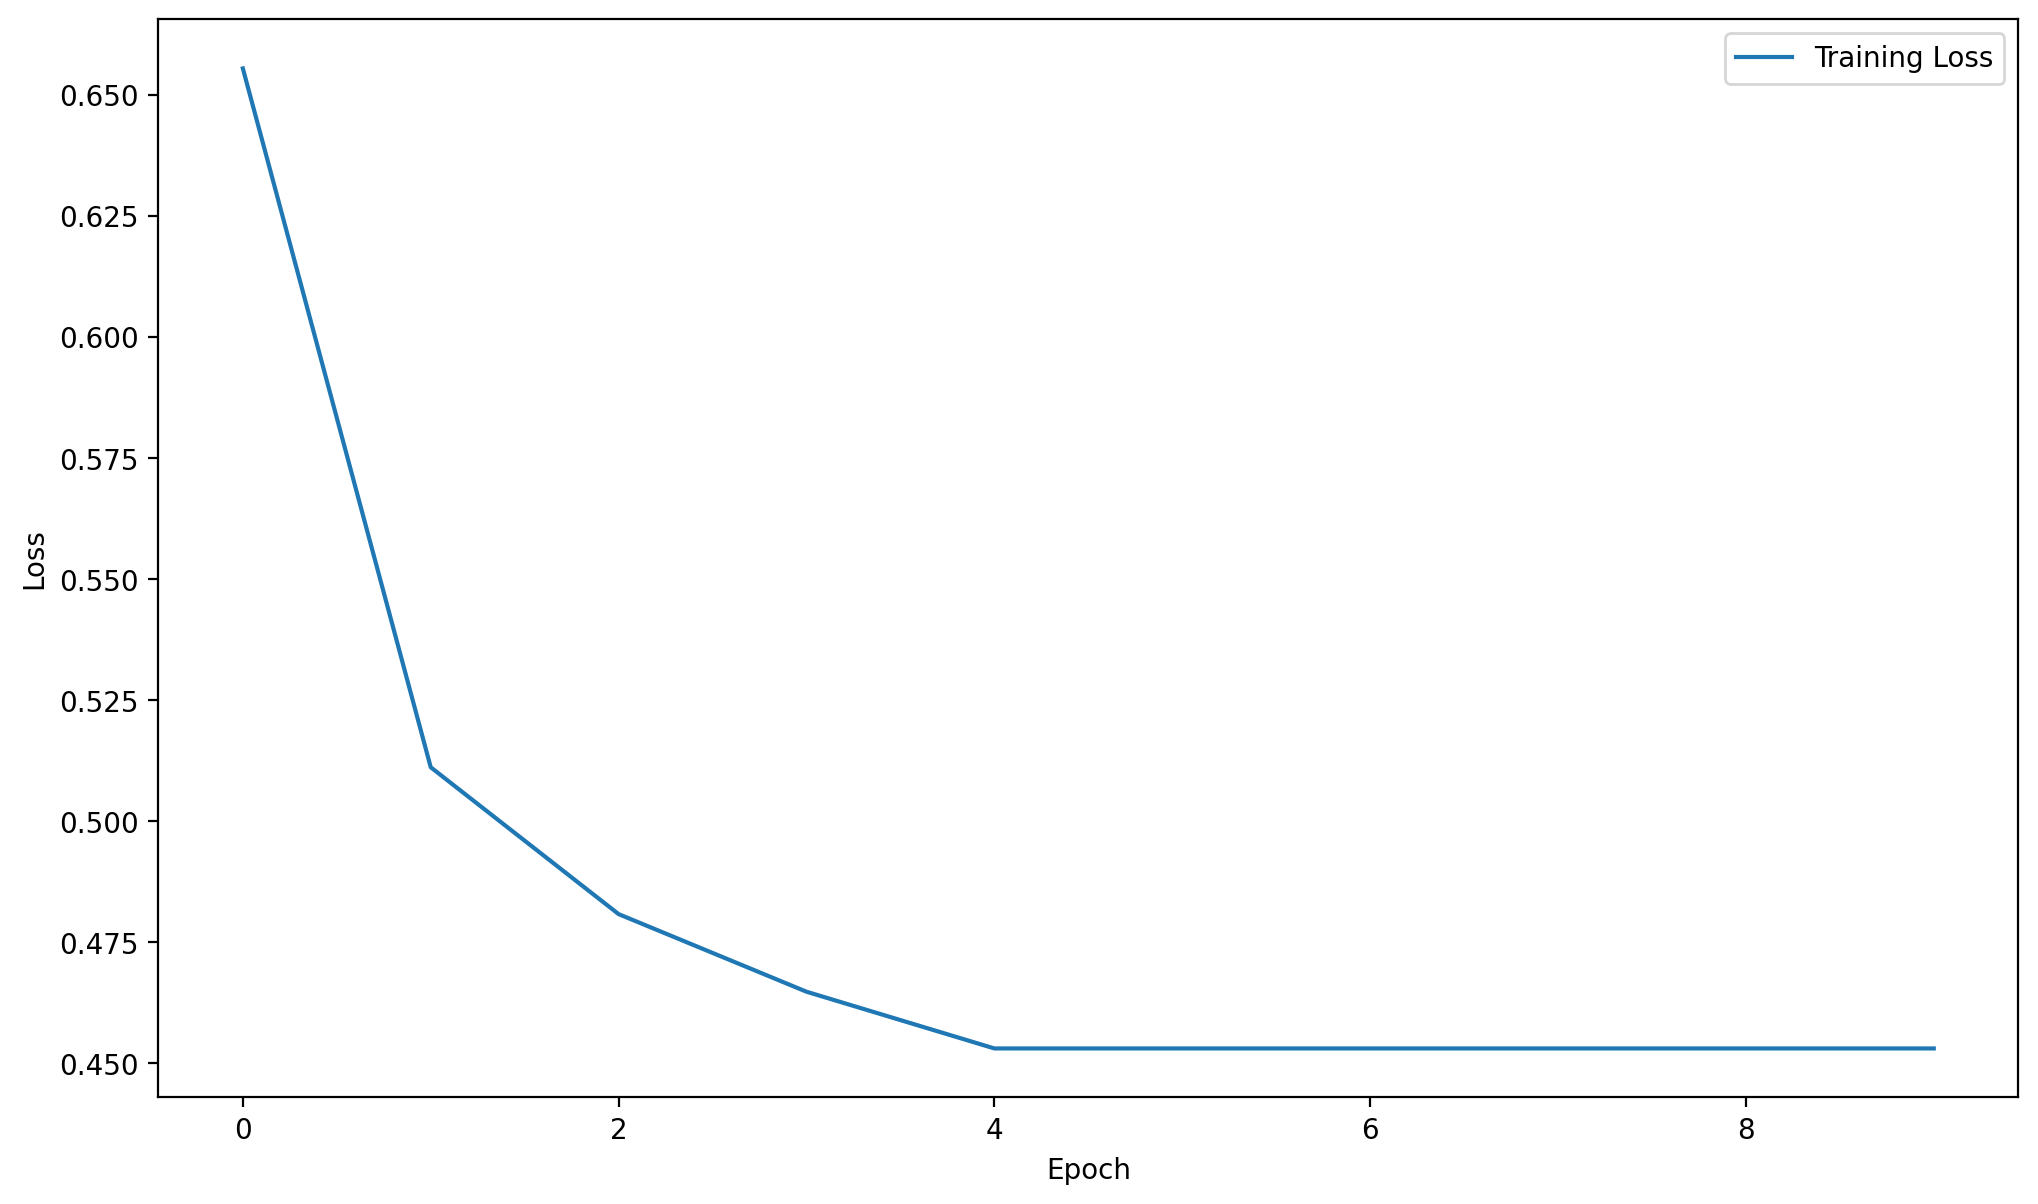

In [30]:
######################################
# Visualization of loss and accuracy
#####################################
with torch.no_grad():# makes sure to be in evaluation mode 
    # we plot now the graph of total_loss values against the epochs.
    plt.plot(total_epoch_loss, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

**END OF WORKSHEET**

Make sure that you answered all the questions on time. This completed `Jupyter Notebook` will be collected and graded. 

Once the `Jupyter Notebook` is collected it can not be modified.